In [1]:
import sys

sys.path.insert(0, "..")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

# Our modules
from src.agents import PPOAgent
from src.mdp import RewardFunction
from src.agents.callbacks.learning_curve_callback import LearningCurveCallback
from src.agents.metrics import TrainingMetrics, EvaluationMetrics
from src.seeds import generate_seeds

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# PPO Agent Training & Evaluation

## 2. Environment Setup


In [2]:
# Configuration
EPISODE_LENGTH = 1000  # days

from src.seeds import TRAINING_SEED

EVAL_SEEDS = generate_seeds(1000, start_index=0)

metadata = {
    "k": 14,
    "Q_max": 30,
    "episode_length": EPISODE_LENGTH,
}

print("🎲 PPO Training Seeds:")
print(f"   Training: {TRAINING_SEED}")
print(f"   Final evaluation: {len(EVAL_SEEDS)} seeds starting at {EVAL_SEEDS[0]}")

🎲 PPO Training Seeds:
   Training: 6173
   Final evaluation: 1000 seeds starting at 6145


In [3]:
from typing import Any
from src.environment.gym_env import InventoryEnvironment


def make_env(
    random_seed: int = TRAINING_SEED,
) -> Any:
    def _init() -> InventoryEnvironment:
        return InventoryEnvironment(
            k=metadata["k"],
            Q_max=metadata["Q_max"],
            episode_length=metadata["episode_length"],
            random_seed=random_seed,
        )

    return _init


vec_env = DummyVecEnv([make_env()])

vec_env = VecNormalize(
    vec_env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    clip_reward=50.0,
    gamma=0.99,
)

print(f"   Base environment: {make_env()}")

   Base environment: <function make_env.<locals>._init at 0x124145120>


## 3. Create and Train PPO Agent


In [5]:
agent = PPOAgent(
    env=vec_env,  # type: ignore
    learning_rate=4e-5,
    gamma=0.99,
    n_steps=1024,
    batch_size=128,
    n_epochs=15,
    clip_range=0.2,
    ent_coef=0.0004,
    gae_lambda=0.95,
    tensorboard_log="./logs/ppo_agent",  # Enable TensorBoard logging
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=TRAINING_SEED,
    verbose=0,
)

print(f"PPO Agent created with seed {TRAINING_SEED}")
print(f"   Effective batch size: {128} samples")

PPO Agent created with seed 6173
   Effective batch size: 128 samples


## 4. Load Previous Checkpoint (Optional)

Uncomment to continue training from a saved checkpoint.

In [6]:
# Load previously trained model weights
agent.load()

# Load VecNormalize statistics to maintain same normalization
vec_env = VecNormalize.load("./models/vec_normalize_ppo.pkl", vec_env)
agent.model.set_env(vec_env)  # Update the model's environment reference

print("✅ Loaded previous checkpoint - ready to continue training!")

PPO weights loaded from models
✅ Loaded previous checkpoint - ready to continue training!


## 5. Training

Train the PPO agent with periodic evaluation.

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=./logs
```


In [9]:
TOTAL_TIMESTEPS = 3_000_000

print(f"🚀 Starting training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"   ≈ {TOTAL_TIMESTEPS // EPISODE_LENGTH:,} episodes\n")

# Initialize plot classes
training_plots = TrainingMetrics()
evaluation_plots = EvaluationMetrics()

# Callbacks
learning_curve_callback = LearningCurveCallback()

""" agent.train(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True,
    callbacks=learning_curve_callback,
) """

print(f"\nTraining complete!")
print(f"  Episodes recorded: {len(learning_curve_callback.episode_rewards)}")

🚀 Starting training for 3,000,000 timesteps...
   ≈ 3,000 episodes


Training complete!
  Episodes recorded: 0


## 6. Save the Trained Model


In [ ]:
agent.save(metadata=metadata)

# Save VecNormalize statistics
vec_env.save("./models/vec_normalize_ppo.pkl")  # type: ignore
print("✅ Model and VecNormalize statistics saved")

---
## Phase 1: Training Analysis

### 1. Learning Curve (Training Stability)
Average Reward per Episode vs. Timesteps.


In [ ]:
window = int(0.1 * (TOTAL_TIMESTEPS // EPISODE_LENGTH))

# Learning Curve: Use data from callback
training_plots.plot_learning_curve(
    episode_timesteps=learning_curve_callback.episode_timesteps,
    episode_rewards=learning_curve_callback.episode_rewards,
    window=max(window, 5),
    title="Learning Curve: PPO Agent Training Progress",
)

---
# Phase 2: Evaluation & Testing
Run N=100 independent test episodes with deterministic policy.


In [7]:
N_TEST_EPISODES = len(EVAL_SEEDS)

reward_fn = RewardFunction()
test_episodes_ppo = []

print(f"🧪 Running {N_TEST_EPISODES} test episodes with deterministic seeds...")

for ep, seed in tqdm(
    enumerate(EVAL_SEEDS), total=N_TEST_EPISODES, desc="Evaluating PPO"
):
    eval_env = DummyVecEnv([make_env(random_seed=seed)])

    eval_env = VecNormalize.load("./models/vec_normalize_ppo.pkl", eval_env)
    eval_env.training = False
    eval_env.norm_reward = False

    obs = eval_env.reset()

    ppo_data = {
        "net_inv_0": [],
        "net_inv_1": [],
        "q0": [],
        "q1": [],
        "demand_0": [],
        "demand_1": [],  # Daily demand per product
        "ordering_cost": [],
        "holding_cost": [],
        "shortage_cost": [],
        "total_daily_cost": [],
    }

    done = False
    while not done:
        # Agent gets normalized observations (same as training)
        action, _ = agent.model.predict(obs, deterministic=True)  # type: ignore

        # Step the vectorized environment
        obs, reward, done_vec, info = eval_env.step(action)
        done = done_vec[0]

        # Get the underlying environment for logging (before normalization)
        raw_env = eval_env.venv.envs[0]  # type: ignore
        action_obj = raw_env.action_space_config.get_action(action[0])
        raw_info = info[0]

        # Log Inventory & Actions
        ppo_data["net_inv_0"].append(raw_info["net_inventory"][0])
        ppo_data["net_inv_1"].append(raw_info["net_inventory"][1])
        ppo_data["q0"].append(action_obj.order_quantities[0])
        ppo_data["q1"].append(action_obj.order_quantities[1])

        # Log Daily Demand per product
        ppo_data["demand_0"].append(raw_info["total_demand"][0])
        ppo_data["demand_1"].append(raw_info["total_demand"][1])

        # Compute Daily Cost Components using RewardFunction
        state = raw_env.get_current_state()
        costs = reward_fn.calculate_costs(state, action_obj)

        # Append to lists
        ppo_data["ordering_cost"].append(costs.ordering_cost)
        ppo_data["holding_cost"].append(costs.holding_cost)
        ppo_data["shortage_cost"].append(costs.shortage_cost)
        ppo_data["total_daily_cost"].append(costs.total_cost)

    test_episodes_ppo.append(ppo_data)
    eval_env.close()

print(
    f"✅ Collected {N_TEST_EPISODES} test episodes for PPO with normalized observations"
)

🧪 Running 1000 test episodes with deterministic seeds...


Evaluating PPO:   0%|          | 0/1000 [00:00<?, ?it/s]

✅ Collected 1000 test episodes for PPO with normalized observations


### Warm-up Period Analysis (Welch's Graphical Procedure)
Since the simulation starts with initial inventory conditions, the early data may be biased (transient phase).   
We use Welch's procedure to identify when steady-state begins.


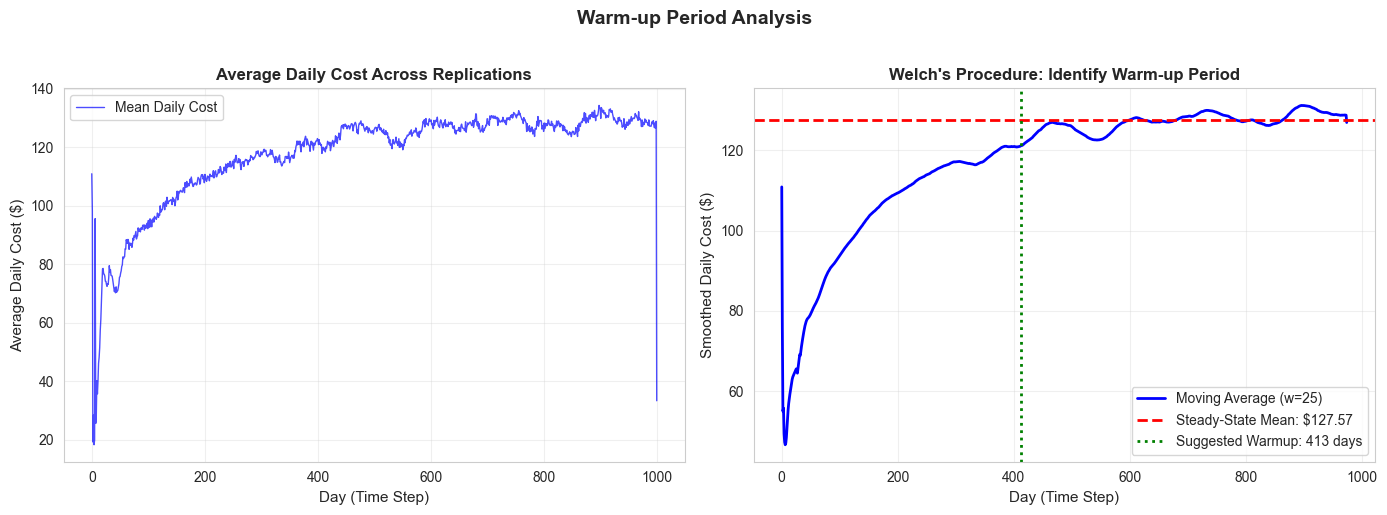

📊 Welch's Procedure Summary:
   Total replications: 1000

✅ Suggested Warmup Length: 413 days
   (Detected where curve stays within 5% of steady-state)

💡 Tip: Visually verify the green line on the right plot.
   Adjust manually if needed based on your domain knowledge.


In [10]:
# Welch's Graphical Procedure for Warm-up Detection
n_days, n_reps, WARMUP_LENGTH = evaluation_plots.plot_welch_procedure(
    test_episodes=test_episodes_ppo,
    window_size=25,
    title="Warm-up Period Analysis",
)

## Cost Component Breakdown (Economic Analysis)

In [11]:
# Compute and print evaluation statistics
stats = evaluation_plots.print_evaluation_statistics(
    test_episodes=test_episodes_ppo,
    warmup_length=WARMUP_LENGTH,
)

📊 COST SUMMARY (1000 episodes, 587 steady-state days)
  Daily Cost: $127.13 ± $0.18 (95% CI)
  Episode Total: $74623.03 ± $816.14


### Daily Cost Evolution

Aggregated daily cost statistics across all test episodes.

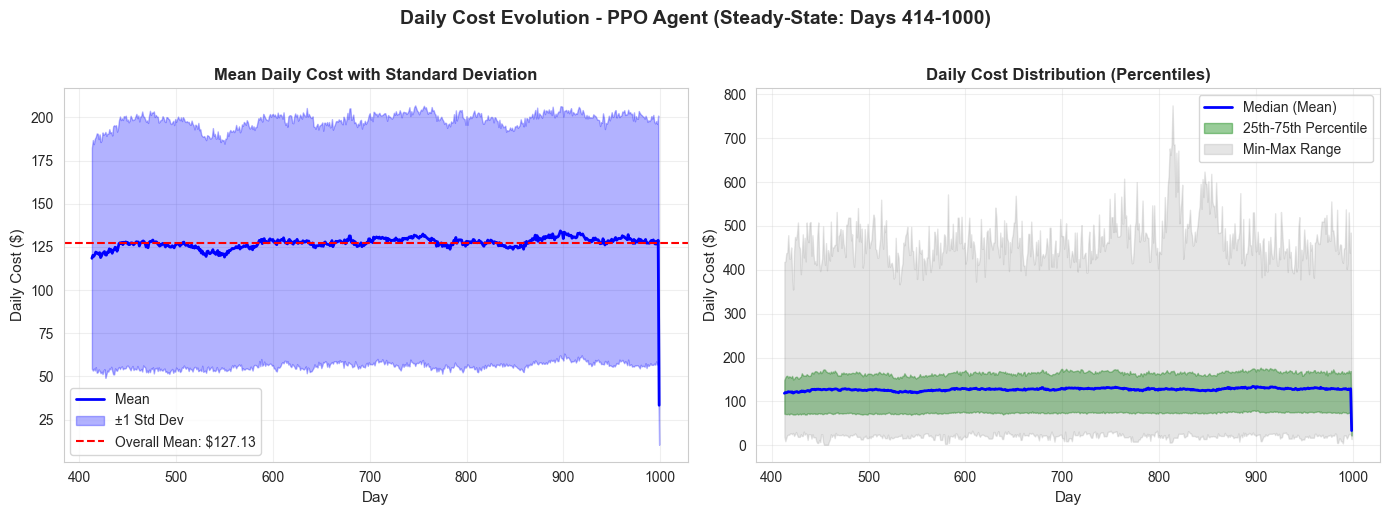

📊 Daily Cost Statistics (Steady-State):
  Mean:   $127.13 ± $71.10
  Median: $127.53
  Min:    $1.00
  Max:    $775.00
  Range:  $774.00


In [12]:
# Daily Cost Analysis
evaluation_plots.plot_daily_cost_analysis(
    test_episodes=test_episodes_ppo,
    warmup_length=WARMUP_LENGTH,
    title="Daily Cost Evolution - PPO Agent",
)

Grouped bar chart decomposed into Ordering, Holding, and Shortage costs.

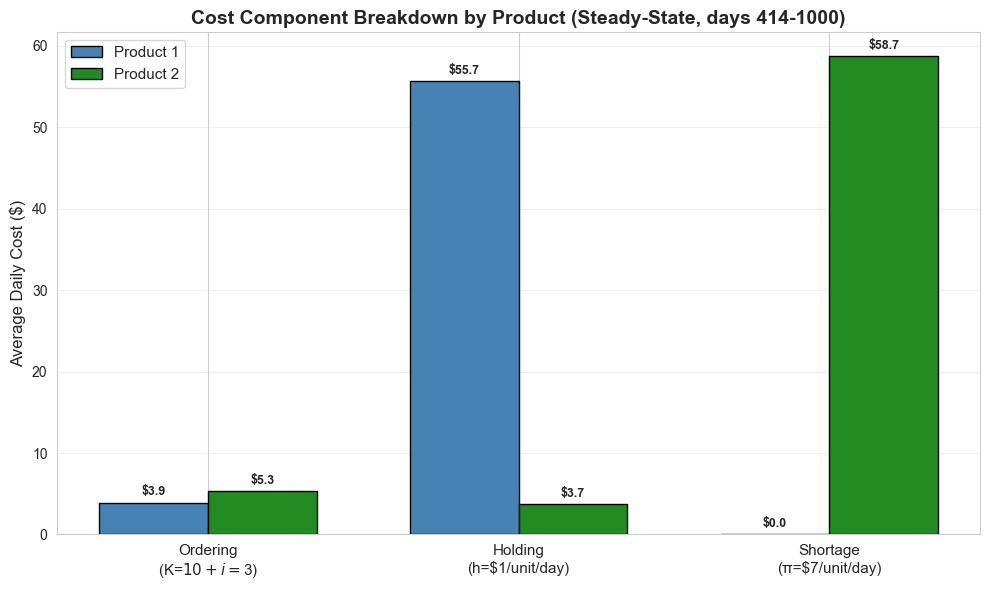

📊 Steady-State Average Daily Cost (days 414-1000):

  Product 1: $59.59 / day
    Ordering: $3.92 (6.6%)
    Holding:  $55.66 (93.4%)
    Shortage: $0.01 (0.0%)

  Product 2: $67.70 / day
    Ordering: $5.28 (7.8%)
    Holding:  $3.70 (5.5%)
    Shortage: $58.71 (86.7%)

------------------------------------------------------------

  TOTAL: $127.29 / day


In [13]:
# Cost Component Breakdown by Product
evaluation_plots.plot_cost_breakdown_by_product(
    test_episodes=test_episodes_ppo,
    warmup_length=WARMUP_LENGTH,
    n_days=n_days,
    title="Cost Component Breakdown by Product",
)

### 4. Operational Time Series (Behavioral Analysis)
Snapshot of inventory levels, orders, and demand over time for selected episodes.


In [14]:
# Select representative episode based on STEADY-STATE costs (excluding warmup)
episode_ss_costs = [
    np.mean(ep["total_daily_cost"][WARMUP_LENGTH:]) for ep in test_episodes_ppo
]
global_ss_mean = np.mean(episode_ss_costs)

# Find episode closest to mean
representative_idx = np.argmin(np.abs(np.array(episode_ss_costs) - global_ss_mean))

# Also find best and worst episodes
best_idx = np.argmin(episode_ss_costs)
worst_idx = np.argmax(episode_ss_costs)

print(f"📊 Episode Selection (Based on Steady-State Costs):")
print(
    f"   Representative: Episode {representative_idx} (cost: ${episode_ss_costs[representative_idx]:.2f})"
)
print(
    f"   Best:           Episode {best_idx} (cost: ${episode_ss_costs[best_idx]:.2f})"
)
print(
    f"   Worst:          Episode {worst_idx} (cost: ${episode_ss_costs[worst_idx]:.2f})"
)
print(f"   Mean across all episodes: ${global_ss_mean:.2f}")

📊 Episode Selection (Based on Steady-State Costs):
   Representative: Episode 256 (cost: $127.11)
   Best:           Episode 705 (cost: $70.30)
   Worst:          Episode 486 (cost: $219.59)
   Mean across all episodes: $127.13



📈 Plotting Representative Episode (Steady-State Period)...


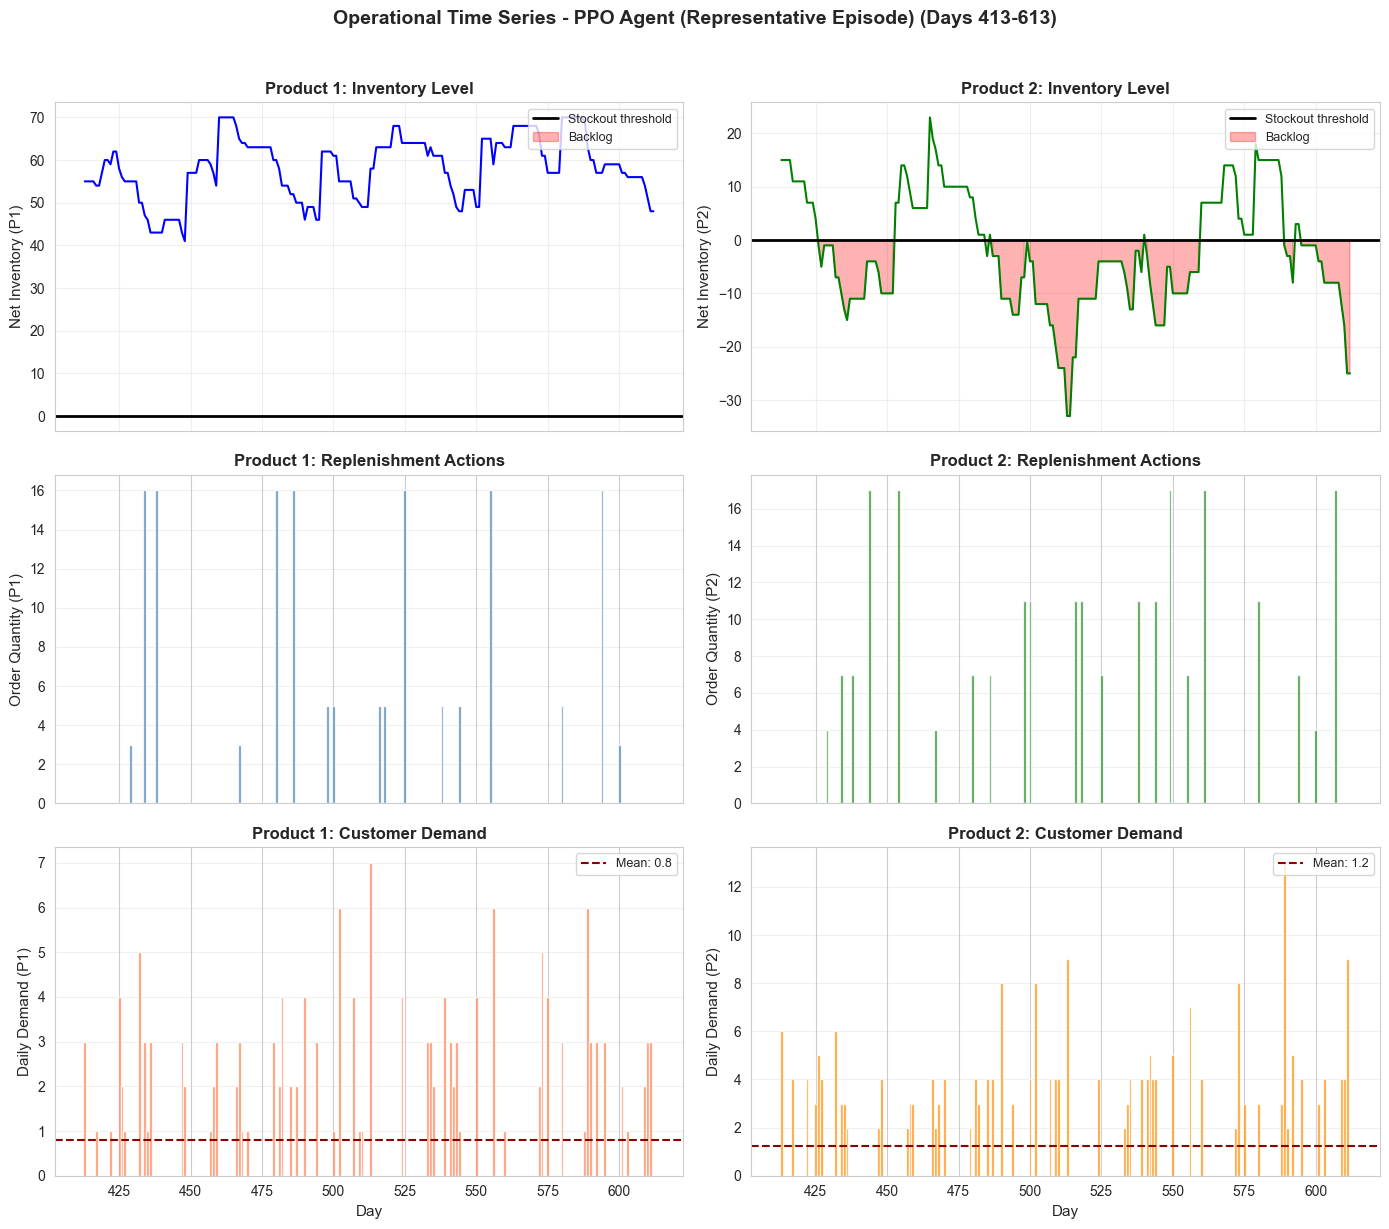

In [17]:
print("\n📈 Plotting Representative Episode (Steady-State Period)...")
evaluation_plots.plot_operational_timeseries(
    episode_data=test_episodes_ppo[representative_idx],
    title="Operational Time Series - PPO Agent (Representative Episode)",
    start_day=WARMUP_LENGTH,
    max_days=200,  # Show only 200 days for clarity
)

### 5. Inventory Distribution Histogram (Risk Profile)
Distribution of Net Inventory levels over all test episodes. Red = Backlog (I < 0), Green = On-Hand (I > 0).


In [ ]:
# Inventory Distribution Histogram (Steady-State only)
evaluation_plots.plot_inventory_histogram(
    test_episodes=test_episodes_ppo,
    warmup_length=WARMUP_LENGTH,
    title="Inventory Distribution - Risk Profile (PPO Agent, Steady-State)",
)